# Import the libraries

In [1]:
# Import necessary libraries for data manipulation, visualization, and forecasting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prophet for time series forecasting
from prophet import Prophet

# Metrics for evaluating model performance
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

# Ignore any warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")

# Set styles for plots to ggplot and fivethirtyeight for aesthetics
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [2]:
# Define a custom function to calculate the Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data

In [3]:
# Load PJM East electricity demand dataset, using the first column as the datetime index
pjme = pd.read_csv('PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


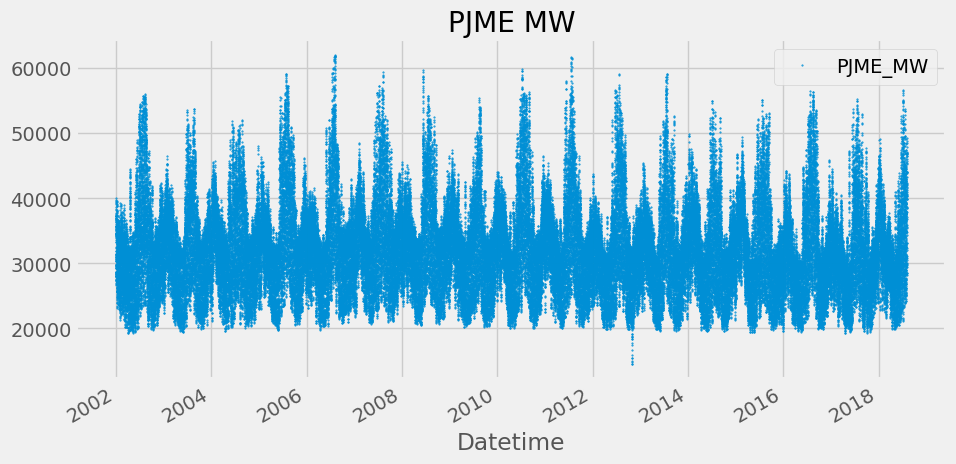

In [4]:
# Define a color palette and plot the dataset to visualize electricity demand over time
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

# Time Series Features

In [5]:
# Define a categorical data type for the days of the week (to be used later)
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

# Function to create time series features from datetime index
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    # Create 'season' feature by binning the date offset into seasons
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday', 
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

# Create features from the dataset and select the target variable 'PJME_MW'
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)  # Combine features and target for visualization

In [6]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


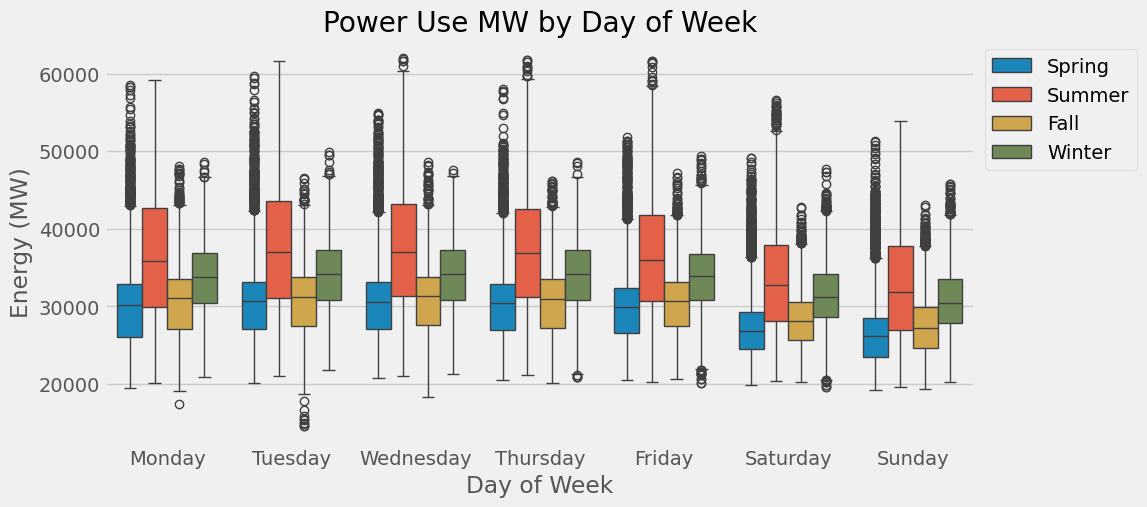

In [7]:
# Create a boxplot to visualize electricity usage by day of the week, colored by season
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(), x='weekday', y='PJME_MW', hue='season', ax=ax, linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()  # Show the plot

# Train / Test Split

In [8]:
# Split the dataset into training (before 2015) and test sets (after 2015)
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [9]:
pjme_train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


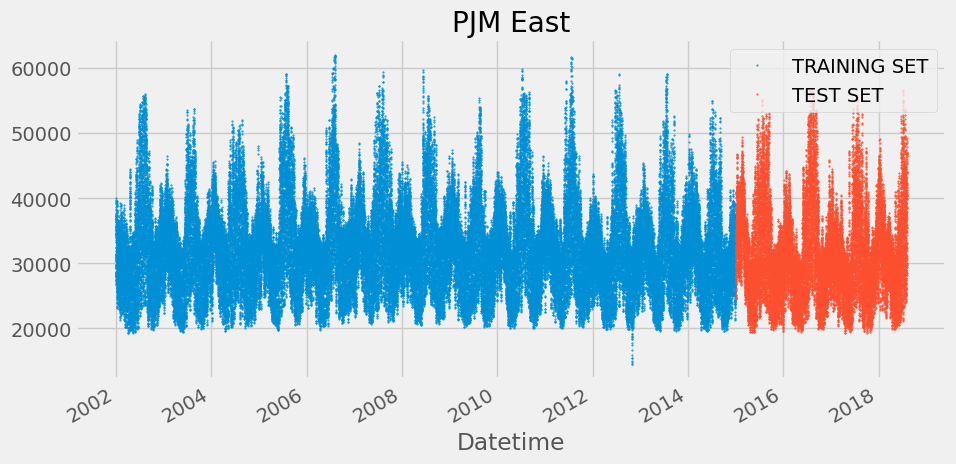

In [10]:
# Plot the train and test sets to visualize the split
pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}) \
    .join(pjme_test.rename(columns={'PJME_MW': 'TEST SET'}), how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

# Prophet Model

In [11]:
# Prepare training data for Prophet, renaming the columns to Prophet's required format
pjme_train_prophet = pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'})

In [12]:
pjme_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [13]:
# Train the Prophet model
model = Prophet()
model.fit(pjme_train_prophet)


15:34:06 - cmdstanpy - INFO - Chain [1] start processing
15:35:56 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Prepare the test set for prediction with Prophet
pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'})

In [15]:
# Predict the future values using the trained Prophet model
pjme_test_fcst = model.predict(pjme_test_prophet)
pjme_test_fcst.head()  # Display the forecasted values

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31211.894503,23954.636820,33091.736730,31211.894503,31211.894503,-2883.398302,-2883.398302,-2883.398302,-4430.336666,...,1281.379696,1281.379696,1281.379696,265.558668,265.558668,265.558668,0.0,0.0,0.0,28328.496201
1,2015-01-01 02:00:00,31211.858086,22617.139343,31108.509244,31211.858086,31211.858086,-4387.803353,-4387.803353,-4387.803353,-5927.240426,...,1272.616748,1272.616748,1272.616748,266.820325,266.820325,266.820325,0.0,0.0,0.0,26824.054733
2,2015-01-01 03:00:00,31211.821670,21525.918329,30460.518636,31211.821670,31211.821670,-5259.520821,-5259.520821,-5259.520821,-6790.292355,...,1262.647997,1262.647997,1262.647997,268.123537,268.123537,268.123537,0.0,0.0,0.0,25952.300848
3,2015-01-01 04:00:00,31211.785253,21166.443966,29862.568644,31211.785253,31211.785253,-5401.095232,-5401.095232,-5401.095232,-6922.160656,...,1251.597094,1251.597094,1251.597094,269.468330,269.468330,269.468330,0.0,0.0,0.0,25810.690021
4,2015-01-01 05:00:00,31211.748836,22271.426954,30957.616972,31211.748836,31211.748836,-4726.796900,-4726.796900,-4726.796900,-6237.251525,...,1239.599895,1239.599895,1239.599895,270.854730,270.854730,270.854730,0.0,0.0,0.0,26484.951936


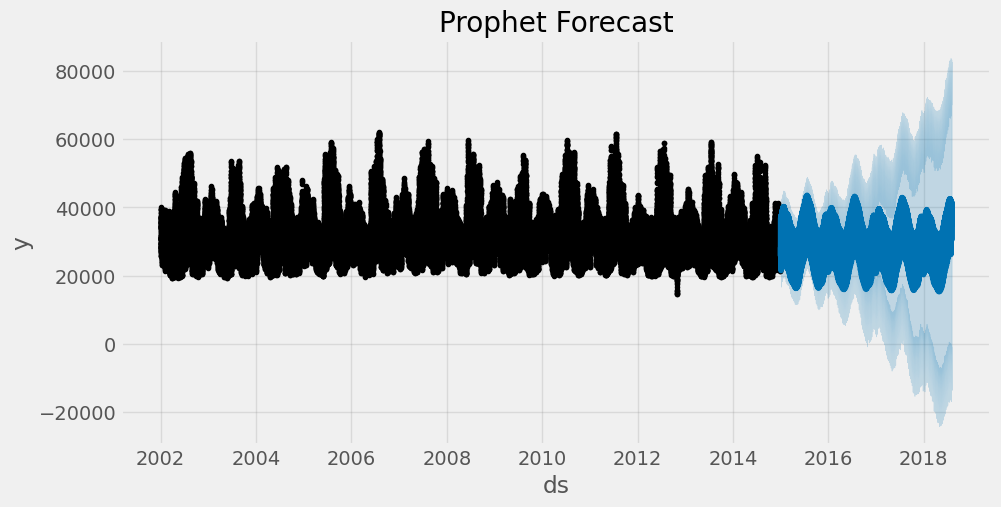

In [16]:
# Plot the forecasted values against the actual test set
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

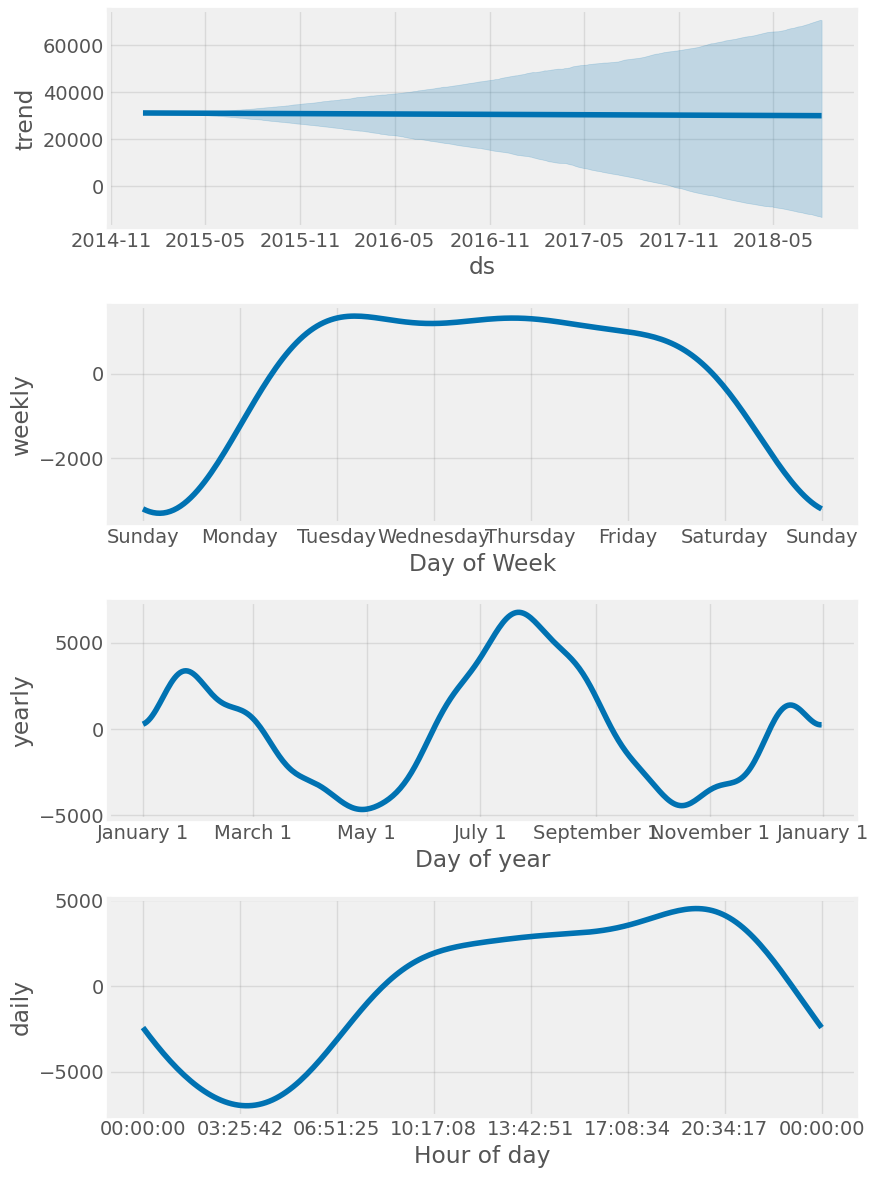

In [17]:
# Plot the components of the forecast (trend, seasonality, etc.)
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actuals

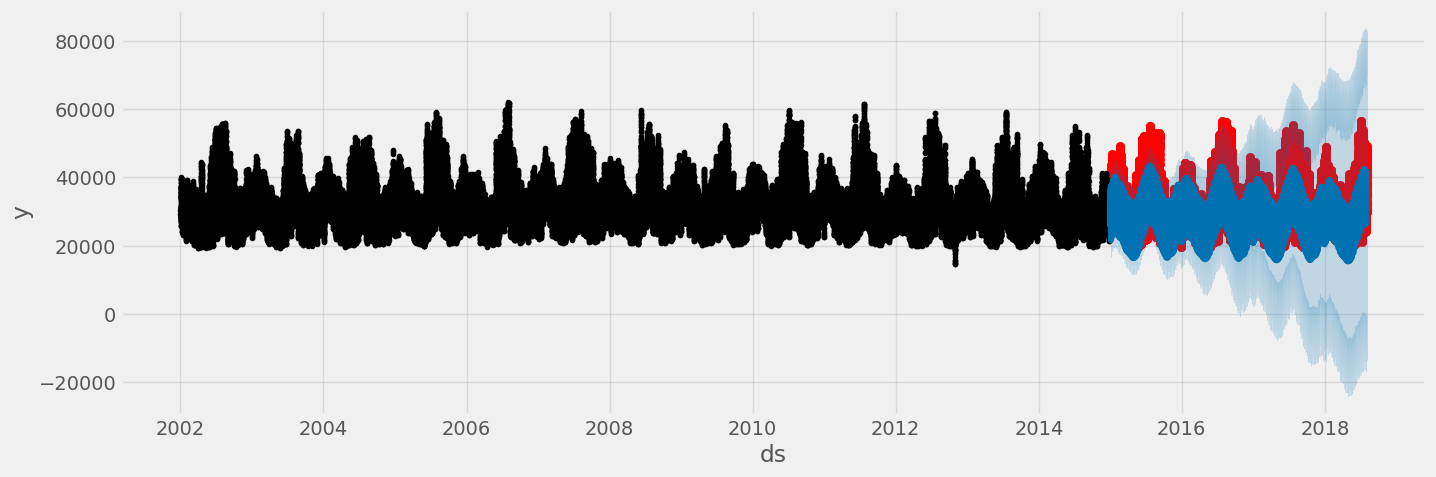

In [18]:
# Plot the forecasted values with actuals to compare
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')  # Actuals in red
fig = model.plot(pjme_test_fcst, ax=ax)

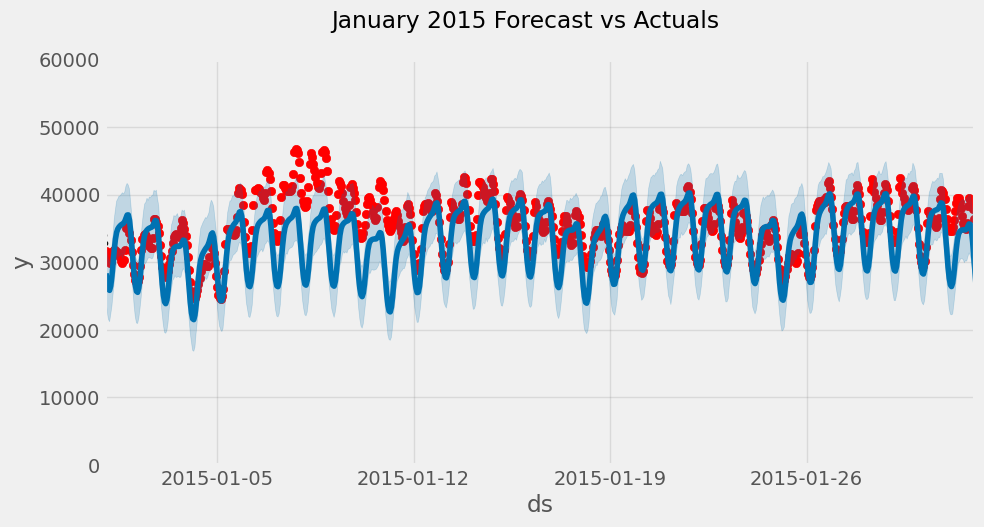

In [19]:
# Zoom into January 2015 for detailed comparison
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')  # Actuals in red
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert the string dates to datetime objects
start_date = pd.to_datetime('01-01-2015')
end_date = pd.to_datetime('02-01-2015')

# Set the time window using datetime objects
ax.set_xbound(lower=start_date, upper=end_date)  # Set the time window
ax.set_ylim(0, 60000)  # Set y-axis limit
plt.suptitle('January 2015 Forecast vs Actuals')
plt.show()


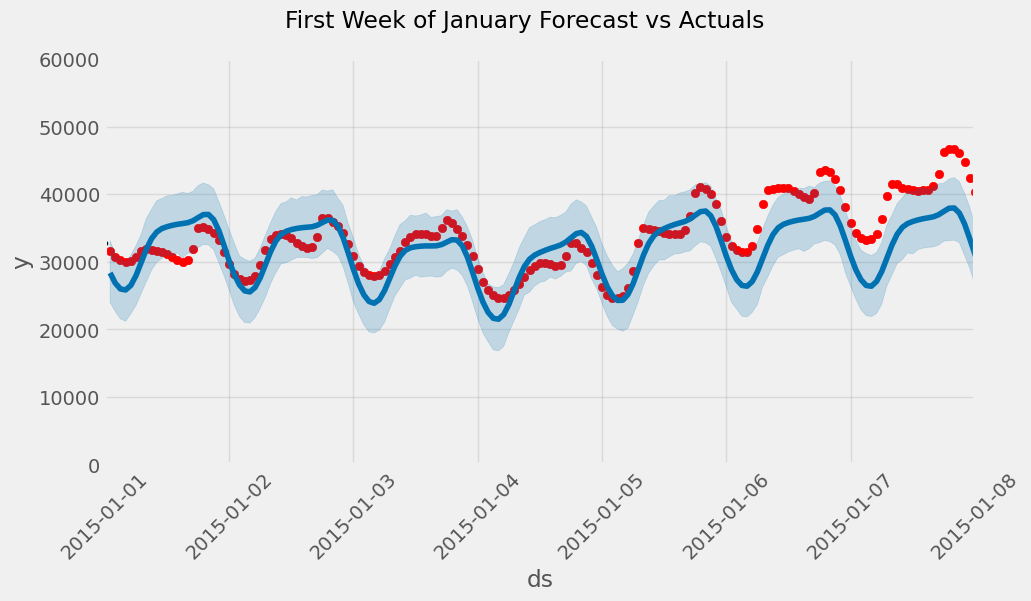

In [20]:
# Zoom into the first week of January 2015 for closer comparison
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')  # Actuals in red
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert the string dates to datetime objects
start_date = pd.to_datetime('01-01-2015')
end_date = pd.to_datetime('01-08-2015')

# Set the time window using datetime objects
ax.set_xbound(lower=start_date, upper=end_date)  # Set the time window
ax.set_ylim(0, 60000)  # Set y-axis limit

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.suptitle('First Week of January Forecast vs Actuals')
plt.show()


# Evaluate the model with Error Metrics

In [21]:
root_mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat'])

6616.988604788084

In [22]:
mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat'])

5181.938581560546

In [23]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst['yhat'])

16.513588824662467

# Adding Holidays

In [24]:
# Import US Federal Holidays to consider them in the forecasting model
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

In [25]:
# Create a DataFrame with holiday information
holidays = cal.holidays(start=pjme.index.min(), end=pjme.index.max(), return_name=True)
holiday_df = pd.DataFrame(data=holidays, columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})  # Rename for Prophet

In [26]:
holiday_df['holiday'].value_counts()

holiday
Birthday of Martin Luther King, Jr.    17
Washington's Birthday                  17
Memorial Day                           17
Independence Day                       17
Labor Day                              16
Columbus Day                           16
Veterans Day                           16
Thanksgiving Day                       16
Christmas Day                          16
New Year's Day                         16
Name: count, dtype: int64

In [27]:
# Train Prophet model with holidays included
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

15:36:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Forecast using the model with holidays
pjme_test_fcst_with_hols = model_with_holidays.predict(df=pjme_test_prophet)

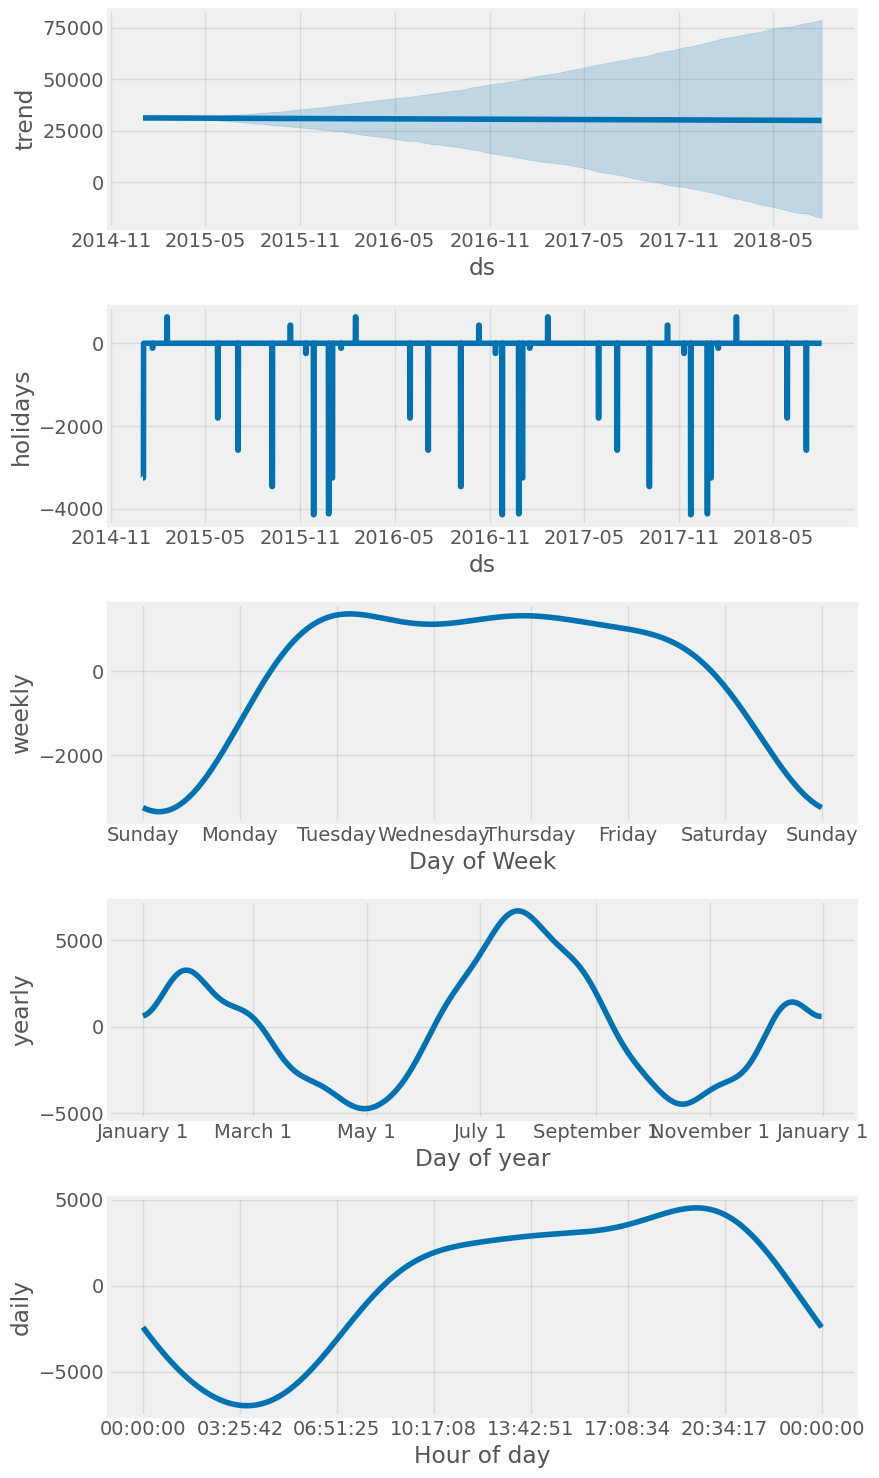

In [29]:
# Plot forecast components with holidays
fig = model_with_holidays.plot_components(pjme_test_fcst_with_hols)
plt.show()

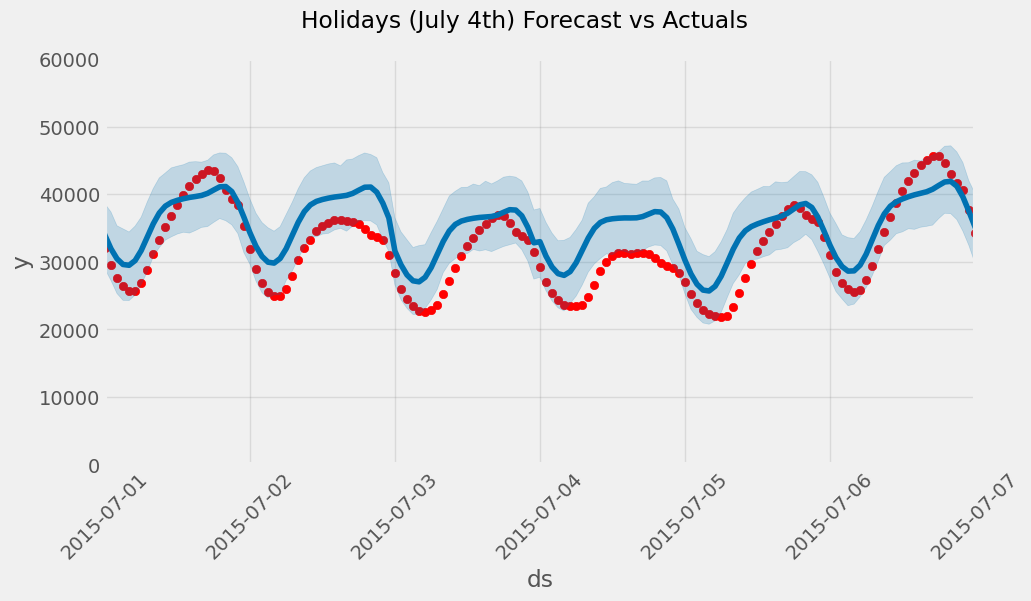

In [30]:
# Plot forecast with holidays alongside actuals for July 4th
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')  # Actuals in red
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)

# Convert the string dates to datetime objects
start_date = pd.to_datetime('07-01-2015')
end_date = pd.to_datetime('07-07-2015')

# Set the time window using datetime objects
ax.set_xbound(lower=start_date, upper=end_date)  # Set the time window
ax.set_ylim(0, 60000)  # Set y-axis limit

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.suptitle('Holidays (July 4th) Forecast vs Actuals')
plt.show()


In [31]:
root_mean_squared_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst_with_hols['yhat'])

6641.510747279933

In [32]:
mean_absolute_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst_with_hols['yhat'])

5201.315931494165

In [33]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'], y_pred=pjme_test_fcst_with_hols['yhat'])

16.56179314698967

# Prediction

In [34]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [35]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25501.325618
1,2015-01-01 02:00:00,23999.365544
2,2015-01-01 03:00:00,23129.777482
3,2015-01-01 04:00:00,22990.067431
4,2015-01-01 05:00:00,23665.948121
